# Librerias

In [1]:
!pip install optuna

In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns; sns.set()  # for plot styling
from difflib import SequenceMatcher
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import statsmodels.api as sm

import statsmodels.formula.api as smf

import optuna
from optuna.samplers import TPESampler
from sklearn.datasets import make_classification

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score


# Carga de datos

In [3]:
regiones_subregiones= pd.read_csv("all.csv")

In [4]:
regiones_subregiones = regiones_subregiones[['name','region','sub-region']].copy()

In [5]:
archivo_taller2_carga=pd.read_csv("gapminder_final.csv")

In [6]:
poblacion = pd.read_excel("pop.xlsx")

In [7]:
areakm2 = pd.read_csv("list_of_countries_by_area-2677j.csv")

In [8]:
babiesperwoman= pd.read_excel("children_per_woman_total_fertility.xlsx")

In [9]:
archivo_taller2_carga.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   country               178 non-null    object 
 1   incomeperperson       175 non-null    float64
 2   alcconsumption        178 non-null    float64
 3   armedforcesrate       174 non-null    float64
 4   breastcancerper100th  177 non-null    float64
 5   co2emissions          176 non-null    float64
 6   femaleemployrate      177 non-null    float64
 7   hivrate               155 non-null    float64
 8   internetuserate       174 non-null    float64
 9   lifeexpectancy        178 non-null    float64
 10  oilperperson          67 non-null     float64
 11  polityscore           167 non-null    float64
 12  relectricperperson    141 non-null    float64
 13  suicideper100th       178 non-null    float64
 14  employrate            177 non-null    float64
 15  urbanrate             1

In [10]:
poblacion

,country,2023
0,Afghanistan,42.2M
1,Angola,36.7M
2,Albania,2.83M
3,Andorra,80.1k
4,UAE,9.52M
...,...,...
192,Samoa,226k
193,Yemen,34.4M
194,South Africa,60.4M
195,Zambia,20.6M


# Unir nueva información

In [11]:
# Paises que se tienen que modificar manualmente:
# Tanzania - Tanzania, United Republic of
# Bolivia -Bolivia (Plurinational State of)
# Moldova - Moldova, Republic of
# Syria - Syrian Arab Republic
# Swaziland - Eswatini
# Russia - Russian Federation
# Slovak Republic- Slovakia
# Venezuela - Venezuela (Bolivarian Republic of)
# Iran- Iran (Islamic Republic of)
# Brunei - Brunei Darussalam
# United Kingdom - United Kingdom of Great Britain and Northern Ireland
# Laos - Lao People's Democratic Republic


In [12]:
def convertir_paises_bien_manual(entrada):
    if "Tanzania, United Republic of" in entrada:
        return "Tanzania"
    elif "Bolivia (Plurinational State of)" in entrada:
        return "Bolivia"
    elif "Moldova, Republic of" in entrada:
        return "Moldova"
    elif "Syrian Arab Republic" in entrada:
        return "Syria"
    elif "Eswatini" in entrada:
        return "Swaziland"
    elif "Russian Federation" in entrada:
        return "Russia"
    elif "Slovakia" in entrada:
        return "Slovak Republic"
    elif "Venezuela (Bolivarian Republic of)" in entrada:
        return "Venezuela"
    elif "Iran (Islamic Republic of)" in entrada:
        return "Iran"
    elif "Brunei Darussalam" in entrada:
        return "Brunei"
    elif "United Kingdom of Great Britain and Northern Ireland" in entrada:
        return "United Kingdom"
    elif "Lao People's Democratic Republic" in entrada:
        return "Laos"
    else:
        return entrada

In [13]:
regiones_subregiones['name'] = regiones_subregiones['name'].apply(convertir_paises_bien_manual)

In [14]:
lista_paises = list(regiones_subregiones['name'])

In [15]:
def convertir_paises_bien(entrada):
    lista_valores=[]
    for pais in lista_paises:
        lista_valores.append(SequenceMatcher(None, entrada, pais).ratio())
    valor_max=max(lista_valores)
    posicion_lista=lista_valores.index(valor_max)
    return lista_paises[posicion_lista]

In [16]:
# SequenceMatcher(None, "United States", "United States Minor Outlying Islands").ratio()

In [17]:
archivo_taller2_carga['country_mod']= archivo_taller2_carga['country'].apply(convertir_paises_bien)

In [18]:
archivo_taller2_region= archivo_taller2_carga.merge(regiones_subregiones, left_on="country_mod", right_on="name",how="left")

In [19]:
# archivo_taller2[archivo_taller2['name'].isna()]

In [20]:
poblacion=poblacion.rename(columns={2023:'poblacion'})

In [21]:
def convertir_paises_bien_manual_pobl(entrada):
    if "USA" in entrada:
        return "United States"
    elif "Lao" in entrada:
        return "Laos"
    elif "UAE" in entrada:
        return "United Arab Emirates"
    elif "Czech Republic" in entrada:
        return "Czech Rep."
    elif "South Korea" in entrada:
        return "Korea, Rep."
    elif "UK" in entrada:
        return "United Kingdom"
    elif "Dominican Republic" in entrada:
        return "Dominican Rep."
    elif "North Macedonia" in entrada:
        return "Macedonia, FYR"
    elif "Kyrgyz Republic" in entrada:
        return "Kyrgyzstan"
    elif "Eswatini" in entrada:
        return "Swaziland"
    elif "Yemen" in entrada:
        return "Yemen, Rep."
    elif "Central African Republic" in entrada:
        return "Central African Rep."
    else:
        return entrada

In [22]:
poblacion['country']= poblacion['country'].str.strip()
poblacion['country']= poblacion['country'].apply(convertir_paises_bien_manual_pobl)

In [23]:
archivo_taller2_pobla= archivo_taller2_region.merge(poblacion, on="country",how="left")

In [24]:
babiesperwoman

,country,2010,2023
0,Aruba,1.70,1.79
1,Afghanistan,5.82,3.65
2,Angola,6.16,5.21
3,Albania,1.65,1.70
4,Netherlands Antilles,1.94,1.81
...,...,...,...
197,Samoa,4.34,3.65
198,Yemen,4.67,3.37
199,South Africa,2.59,2.29
200,Zambia,5.40,4.60


In [25]:
babiesperwoman['country']= babiesperwoman['country'].str.strip()
babiesperwoman['country']= babiesperwoman['country'].apply(convertir_paises_bien_manual_pobl)

In [26]:
babiesperwoman= babiesperwoman[['country',2010]]

In [27]:
babiesperwoman=babiesperwoman.rename(columns={2010:'babiesperwoman'})

In [28]:
archivo_taller2_bbw= archivo_taller2_pobla.merge(babiesperwoman, on="country",how="left")

In [29]:
archivo_taller2_bbw[archivo_taller2_bbw['babiesperwoman'].isna()]

,country,incomeperperson,alcconsumption,armedforcesrate,breastcancerper100th,co2emissions,femaleemployrate,hivrate,internetuserate,lifeexpectancy,...,relectricperperson,suicideper100th,employrate,urbanrate,country_mod,name,region,sub-region,poblacion,babiesperwoman


In [30]:
# archivo_taller2= archivo_taller2.drop(columns=['country_y'])

In [31]:
areakm2_mod = areakm2.drop(columns=['Alpha-2 code','Numeric Code','Nationality'])
areakm2_mod = areakm2_mod.rename(columns={'Country / Dependency':'country','Total in km (mi)':'total_areakm2','Land in km (mi)':'tierra_area_km2',
                                         'Water in km (mi)':'agua_area_km2'})
areakm2_mod

,S.No.,country,total_areakm2,tierra_area_km2,agua_area_km2,% water
0,1,Russia,"17,098,246 (6,601,670)","16,378,410 (6,323,740)","719,836 (277,930)",4.21
1,2,Canada,"9,984,670 (3,855,100)","9,093,507 (3,511,023)","891,163 (344,080)",8.93
2,3,China,"9,596,961 (3,705,407)","9,326,410 (3,600,950)","270,550 (104,460)",2.82
3,4,United States,"9,833,517 (3,796,742)","9,147,593 (3,531,905)","685,924 (264,837)",6.97
4,5,Brazil,"8,515,767 (3,287,956)","8,460,415 (3,266,584)","55,352 (21,372)",0.65
...,...,...,...,...,...,...
261,262,Monaco,2.02 (0.78),2.02 (0.78),0 (0),0
262,263,Vatican City,0.49 (0.19),0.49 (0.19),0 (0),0
263,NaN,World,"510,072,000 (196,940,000)","148,940,000 (57,510,000)","361,132,000 (139,434,000)",70.8
264,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
areakm2_mod= areakm2_mod[(~(areakm2_mod['S.No.'].isna()) & ~(areakm2_mod['S.No.'].str.contains("https",na=False)))]
areakm2_mod= areakm2_mod[(~(areakm2_mod['total_areakm2'].isna()) & ~(areakm2_mod['tierra_area_km2'].isna()) & ~(areakm2_mod['agua_area_km2'].isna()))]

In [33]:
areakm2_mod['total_areakm2']= areakm2_mod['total_areakm2'].str.strip()
areakm2_mod['tierra_area_km2']= areakm2_mod['tierra_area_km2'].str.strip()
areakm2_mod['agua_area_km2']= areakm2_mod['agua_area_km2'].str.strip()

In [34]:
def solodejarnumkm2(entrada):
    salida = entrada.split(" ")[0].replace(",","")
    return salida

In [35]:
areakm2_mod['total_areakm2']= areakm2_mod['total_areakm2'].apply(solodejarnumkm2)
areakm2_mod['tierra_area_km2']= areakm2_mod['tierra_area_km2'].apply(solodejarnumkm2)
areakm2_mod['agua_area_km2']= areakm2_mod['agua_area_km2'].apply(solodejarnumkm2)

In [36]:
def convertir_paises_bien_manual_area(entrada):
    if "Czech Republic" in entrada:
        return "Czech Rep."
    elif "South Korea" in entrada:
        return "Korea, Rep."
    elif "Dominican Republic" in entrada:
        return "Dominican Rep."
    elif "North Macedonia" in entrada:
        return "Macedonia, FYR"
    elif "Eswatini" in entrada:
        return "Swaziland"
    elif "Yemen" in entrada:
        return "Yemen, Rep."
    elif "Central African Republic" in entrada:
        return "Central African Rep."
    elif "DR Congo" in entrada:
        return "Congo, Dem. Rep."
    elif "Ivory Coast" in entrada:
        return "Cote d'Ivoire"
    elif "Congo" in entrada:
        return "Congo, Rep."
    elif "Cabo Verde" in entrada:
        return "Cape Verde"
    elif "Slovakia" in entrada:
        return "Slovak Republic"
    elif "East Timor" in entrada:
        return "Timor-Leste"
    else:
        return entrada

In [37]:
areakm2_mod= areakm2_mod.drop(columns=['S.No.'])

In [38]:
areakm2_mod['country']= areakm2_mod['country'].apply(convertir_paises_bien_manual_area)

In [39]:
areakm2_mod[areakm2_mod['country'].str.contains("Congo")]

,country,total_areakm2,tierra_area_km2,agua_area_km2,% water
10,"Congo, Dem. Rep.",2344858,2267048,77810,3.32
66,"Congo, Rep.",342000,341500,500,0.15


In [40]:
archivo_taller2= archivo_taller2_bbw.merge(areakm2_mod, on="country",how="left")

In [41]:
archivo_taller2[archivo_taller2['total_areakm2'].isna()]['country'].unique()

array([], dtype=object)

In [42]:
archivo_taller2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178 entries, 0 to 177
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   country               178 non-null    object 
 1   incomeperperson       175 non-null    float64
 2   alcconsumption        178 non-null    float64
 3   armedforcesrate       174 non-null    float64
 4   breastcancerper100th  177 non-null    float64
 5   co2emissions          176 non-null    float64
 6   femaleemployrate      177 non-null    float64
 7   hivrate               155 non-null    float64
 8   internetuserate       174 non-null    float64
 9   lifeexpectancy        178 non-null    float64
 10  oilperperson          67 non-null     float64
 11  polityscore           167 non-null    float64
 12  relectricperperson    141 non-null    float64
 13  suicideper100th       178 non-null    float64
 14  employrate            177 non-null    float64
 15  urbanrate             1

In [43]:
# archivo_taller2.to_excel("prueba_paises.xlsx")

# Limpieza de datos y preparación de los datos

In [44]:
# Países sin fuerzas militares
archivo_taller2[archivo_taller2['armedforcesrate'].isna()]

,country,incomeperperson,alcconsumption,armedforcesrate,breastcancerper100th,co2emissions,femaleemployrate,hivrate,internetuserate,lifeexpectancy,...,country_mod,name,region,sub-region,poblacion,babiesperwoman,total_areakm2,tierra_area_km2,agua_area_km2,% water
56,Swaziland,1810.230533,5.05,NaN,12.3,2.270400e+07,47.099998,25.9,9.007736,48.718,...,Swaziland,Swaziland,Africa,Sub-Saharan Africa,1.21M,3.53,17364,17204,160,0.92
58,Solomon Islands,1144.102193,1.37,NaN,29.8,5.210333e+06,51.299999,NaN,5.001375,67.852,...,Solomon Islands,Solomon Islands,Oceania,Melanesia,740k,4.24,28896,27986,910,3.15
158,Bhutan,1324.194906,0.54,NaN,21.8,6.024333e+06,39.900002,0.2,13.598876,67.185,...,Bhutan,Bhutan,Asia,Southern Asia,787k,2.38,38394,38394,0,0
176,Comoros,336.368749,0.28,NaN,19.5,2.368667e+06,59.299999,0.1,5.098265,61.061,...,Comoros,Comoros,Africa,Sub-Saharan Africa,852k,4.92,1862,1862,0,0


In [45]:
# País con una población de 1 millón de habitantes , por lo que no es un posible 0 , por lo tanto , se procederá a promediar la media o mediana de los países de su región (Oceania)
# Además que con una población de los países de la región parecida
archivo_taller2[archivo_taller2['breastcancerper100th'].isna()]

,country,incomeperperson,alcconsumption,armedforcesrate,breastcancerper100th,co2emissions,femaleemployrate,hivrate,internetuserate,lifeexpectancy,...,country_mod,name,region,sub-region,poblacion,babiesperwoman,total_areakm2,tierra_area_km2,agua_area_km2,% water
164,Timor-Leste,369.572954,0.74,0.234286,NaN,850666.6667,54.700001,NaN,0.210066,62.475,...,Timor-Leste,Timor-Leste,Asia,South-eastern Asia,1.36M,6.23,14919,14919,0,0


In [46]:
# Con Emisiones de CO2 se realiza lo mismo que lo anterior
archivo_taller2[archivo_taller2['co2emissions'].isna()]

,country,incomeperperson,alcconsumption,armedforcesrate,breastcancerper100th,co2emissions,femaleemployrate,hivrate,internetuserate,lifeexpectancy,...,country_mod,name,region,sub-region,poblacion,babiesperwoman,total_areakm2,tierra_area_km2,agua_area_km2,% water
28,Lesotho,495.734247,5.56,0.217653,13.1,NaN,49.799999,23.6,3.860565,48.196,...,Lesotho,Lesotho,Africa,Sub-Saharan Africa,2.33M,3.30,30355,30355,0,0
126,Trinidad and Tobago,10480.817200,6.16,0.581165,51.1,NaN,50.500000,1.5,48.516818,70.124,...,Trinidad and Tobago,Trinidad and Tobago,Americas,Latin America and the Caribbean,1.53M,1.81,5130,5128,0,0


In [47]:
# Se realiza lo mismo que lo anterior
archivo_taller2[archivo_taller2['femaleemployrate'].isna()]

,country,incomeperperson,alcconsumption,armedforcesrate,breastcancerper100th,co2emissions,femaleemployrate,hivrate,internetuserate,lifeexpectancy,...,country_mod,name,region,sub-region,poblacion,babiesperwoman,total_areakm2,tierra_area_km2,agua_area_km2,% water
127,Djibouti,895.31834,1.87,3.451546,19.5,14054333.33,NaN,2.5,6.497924,57.937,...,Djibouti,Djibouti,Africa,Sub-Saharan Africa,1.14M,3.3,23200,23180,20,0.09


In [48]:
# Se realiza lo mismo que lo anterior
archivo_taller2[archivo_taller2['hivrate'].isna()]

,country,incomeperperson,alcconsumption,armedforcesrate,breastcancerper100th,co2emissions,femaleemployrate,hivrate,internetuserate,lifeexpectancy,...,country_mod,name,region,sub-region,poblacion,babiesperwoman,total_areakm2,tierra_area_km2,agua_area_km2,% water
1,Albania,1914.996551,7.29,1.024736,57.4,2.237473e+08,42.099998,NaN,44.989947,76.918,...,Albania,Albania,Europe,Southern Europe,2.83M,1.65,28748,27398,1350,4.7
13,Iraq,736.268054,0.47,7.737913,31.7,2.421918e+09,12.400000,NaN,2.471948,69.042,...,Iraq,Iraq,Asia,Western Asia,45.5M,4.56,438317,437367,950,0.22
18,"Macedonia, FYR",2221.185664,8.94,2.101467,52.1,1.688830e+08,26.799999,NaN,51.914184,74.847,...,North Macedonia,North Macedonia,Europe,Southern Europe,2.09M,1.47,25713,25433,280,1.09
26,Saudi Arabia,9425.325870,0.34,2.618296,24.7,7.861553e+09,17.700001,NaN,41.000128,73.911,...,Saudi Arabia,Saudi Arabia,Asia,Western Asia,36.9M,2.96,2149690,2149690,0,0
29,Cape Verde,1959.844472,4.98,0.483325,28.1,5.214000e+06,43.599998,NaN,29.999940,74.156,...,Cabo Verde,Cabo Verde,Africa,Sub-Saharan Africa,599k,2.67,4033,4033,0,0
46,"Yemen, Rep.",610.357367,0.20,2.316235,35.1,2.348647e+08,20.299999,NaN,12.349750,65.493,...,Yemen,Yemen,Asia,Western Asia,34.4M,4.67,555000,555000,0,0
54,Syria,1525.780116,1.49,5.955847,44.8,1.436893e+09,16.700001,NaN,20.663156,75.850,...,Syria,Syria,Asia,Western Asia,23.2M,3.21,185180,183630,1550,0.84
58,Solomon Islands,1144.102193,1.37,NaN,29.8,5.210333e+06,51.299999,NaN,5.001375,67.852,...,Solomon Islands,Solomon Islands,Oceania,Melanesia,740k,4.24,28896,27986,910,3.15
64,Ethiopia,220.891248,4.10,0.361708,24.7,1.199587e+08,73.000000,NaN,0.749996,59.274,...,Ethiopia,Ethiopia,Africa,Sub-Saharan Africa,127M,4.92,1104300,1000000,104300,0.7
68,Kuwait,NaN,0.10,1.609548,31.8,1.712755e+09,42.000000,NaN,38.260234,74.576,...,Kuwait,Kuwait,Asia,Western Asia,4.31M,2.22,17818,17818,0,0


In [49]:
# Se realiza lo mismo que lo anterior
archivo_taller2[archivo_taller2['internetuserate'].isna()]

,country,incomeperperson,alcconsumption,armedforcesrate,breastcancerper100th,co2emissions,femaleemployrate,hivrate,internetuserate,lifeexpectancy,...,country_mod,name,region,sub-region,poblacion,babiesperwoman,total_areakm2,tierra_area_km2,agua_area_km2,% water
98,Sudan,523.950151,2.56,0.969499,22.5,2.250197e+08,27.900000,1.1,NaN,61.452,...,Sudan,Sudan,Africa,Northern Africa,48.1M,4.88,1861484,1731671,129813,6.97
111,Sudan,523.950151,2.56,0.969499,22.5,2.250197e+08,27.900000,1.1,NaN,61.452,...,Sudan,Sudan,Africa,Northern Africa,48.1M,4.88,1861484,1731671,129813,6.97
123,Sierra Leone,268.331790,9.48,0.523548,28.1,2.975867e+07,63.400002,1.6,NaN,47.794,...,Sierra Leone,Sierra Leone,Africa,Sub-Saharan Africa,8.79M,5.20,71740,71620,120,0.17
134,Myanmar,NaN,0.58,1.912965,20.2,3.229600e+08,66.500000,0.6,NaN,65.193,...,Myanmar,Myanmar,Asia,South-eastern Asia,54.6M,2.41,676578,653508,23070,3.41


In [50]:
# Se realiza lo mismo que lo anterior
archivo_taller2[archivo_taller2['polityscore'].isna()]

,country,incomeperperson,alcconsumption,armedforcesrate,breastcancerper100th,co2emissions,femaleemployrate,hivrate,internetuserate,lifeexpectancy,...,country_mod,name,region,sub-region,poblacion,babiesperwoman,total_areakm2,tierra_area_km2,agua_area_km2,% water
3,Barbados,9243.587053,6.42,0.663956,62.5,3.616067e+07,60.299999,1.4,70.028599,76.835,...,Barbados,Barbados,Americas,Latin America and the Caribbean,282k,1.78,430,431,0,0
29,Cape Verde,1959.844472,4.98,0.483325,28.1,5.214000e+06,43.599998,NaN,29.999940,74.156,...,Cabo Verde,Cabo Verde,Africa,Sub-Saharan Africa,599k,2.67,4033,4033,0,0
40,Suriname,2668.020519,6.56,1.058419,30.0,8.631700e+07,30.400000,1.0,31.568098,70.563,...,Suriname,Suriname,Americas,Latin America and the Caribbean,623k,2.52,163820,156000,7820,4.77
69,Malta,11066.784140,4.10,1.144319,76.1,7.378433e+07,30.100000,0.1,63.077993,79.634,...,Malta,Malta,Europe,Southern Europe,535k,1.39,316,316,0,0
79,Bahamas,19630.540550,8.65,0.545286,54.4,1.375550e+08,60.700001,3.1,42.984580,75.620,...,Bahamas,Bahamas,Americas,Latin America and the Caribbean,413k,1.87,13943,10010,3870,27.88
81,Iceland,33945.314420,7.38,0.066100,90.0,9.277033e+07,69.599998,0.3,95.638113,81.804,...,Iceland,Iceland,Europe,Northern Europe,375k,2.07,103000,100250,2750,2.67
97,Luxembourg,52301.587180,12.84,0.731336,82.5,5.920127e+08,45.900002,0.3,90.079527,79.963,...,Luxembourg,Luxembourg,Europe,Western Europe,655k,1.58,2586,2586,0,0
131,Belize,3545.652174,5.92,0.758356,29.8,1.405800e+07,38.799999,2.3,12.645733,76.072,...,Belize,Belize,Americas,Latin America and the Caribbean,411k,2.72,22966,22806,160,0.7
133,Brunei,17092.460000,1.86,4.683989,20.6,2.542063e+08,55.500000,NaN,49.989975,78.005,...,Brunei,Brunei,Asia,South-eastern Asia,453k,1.84,5765,5265,500,8.67
135,Bosnia and Herzegovina,2183.344867,9.60,0.462847,58.9,2.364193e+08,34.900002,NaN,52.002061,75.670,...,Bosnia and Herzegovina,Bosnia and Herzegovina,Europe,Southern Europe,3.21M,1.31,51209,51187,10,0.02


In [51]:
# Se realiza lo mismo que lo anterior
archivo_taller2[archivo_taller2['relectricperperson'].isna()]

,country,incomeperperson,alcconsumption,armedforcesrate,breastcancerper100th,co2emissions,femaleemployrate,hivrate,internetuserate,lifeexpectancy,...,country_mod,name,region,sub-region,poblacion,babiesperwoman,total_areakm2,tierra_area_km2,agua_area_km2,% water
2,Central African Rep.,239.518749,3.17,0.148659,16.5,8.338000e+06,62.900002,4.7,2.300027,48.398,...,Central African Republic,Central African Republic,Africa,Sub-Saharan Africa,5.74M,5.22,622984,622984,0,0
3,Barbados,9243.587053,6.42,0.663956,62.5,3.616067e+07,60.299999,1.4,70.028599,76.835,...,Barbados,Barbados,Americas,Latin America and the Caribbean,282k,1.78,430,431,0,0
6,Mauritania,609.131206,0.11,1.551262,28.1,5.681867e+07,45.299999,0.7,2.999803,58.582,...,Mauritania,Mauritania,Africa,Sub-Saharan Africa,4.86M,4.98,1030700,1025520,4480,0.44
11,Equatorial Guinea,8654.536845,6.12,0.397654,16.5,2.612500e+07,39.599998,5.0,6.003437,51.088,...,Equatorial Guinea,Equatorial Guinea,Africa,Sub-Saharan Africa,1.71M,5.21,28051,28051,0,0
14,Mali,269.892881,0.99,0.326978,18.2,1.751567e+07,34.400002,1.0,2.699966,51.444,...,Mali,Mali,Africa,Sub-Saharan Africa,23.3M,6.55,1240192,1220190,20002,1.61
18,"Macedonia, FYR",2221.185664,8.94,2.101467,52.1,1.688830e+08,26.799999,NaN,51.914184,74.847,...,North Macedonia,North Macedonia,Europe,Southern Europe,2.09M,1.47,25713,25433,280,1.09
20,Fiji,2230.676374,2.76,1.177268,31.2,3.571700e+07,36.799999,0.1,14.830736,69.245,...,Fiji,Fiji,Oceania,Melanesia,936k,2.67,18272,18274,0,0
28,Lesotho,495.734247,5.56,0.217653,13.1,NaN,49.799999,23.6,3.860565,48.196,...,Lesotho,Lesotho,Africa,Sub-Saharan Africa,2.33M,3.30,30355,30355,0,0
29,Cape Verde,1959.844472,4.98,0.483325,28.1,5.214000e+06,43.599998,NaN,29.999940,74.156,...,Cabo Verde,Cabo Verde,Africa,Sub-Saharan Africa,599k,2.67,4033,4033,0,0
31,Uganda,377.421113,16.40,0.344518,18.3,4.979333e+07,80.000000,6.5,12.500255,54.116,...,Uganda,Uganda,Africa,Sub-Saharan Africa,48.6M,6.15,241550,197100,43938,18.23


In [52]:
# Se realiza lo mismo que lo anterior
archivo_taller2[archivo_taller2['employrate'].isna()]

,country,incomeperperson,alcconsumption,armedforcesrate,breastcancerper100th,co2emissions,femaleemployrate,hivrate,internetuserate,lifeexpectancy,...,country_mod,name,region,sub-region,poblacion,babiesperwoman,total_areakm2,tierra_area_km2,agua_area_km2,% water
127,Djibouti,895.31834,1.87,3.451546,19.5,14054333.33,NaN,2.5,6.497924,57.937,...,Djibouti,Djibouti,Africa,Sub-Saharan Africa,1.14M,3.3,23200,23180,20,0.09


In [53]:
archivo_taller2['poblacion']

0      5.06M
1      2.83M
2      5.74M
3       282k
4      58.9M
       ...  
173     128M
174     1.3M
175     2.6M
176     852k
177     340M
Name: poblacion, Length: 178, dtype: object

In [54]:
def pasar_letras_a_numeros_poblacion(entrada):
    multiplo=0
    if "M" in entrada:
        multiplo= 1000000
    elif "k" in entrada:
        multiplo=100000
    elif "B" in entrada:
        multiplo=1000000000
    numero_inicio= entrada.replace("M","")
    numero_inicio= numero_inicio.replace("k","")
    numero_inicio= numero_inicio.replace("B","")
    numero_inicio= float(numero_inicio)
    return numero_inicio*multiplo

In [55]:
archivo_taller2_fil = archivo_taller2.dropna(subset=['incomeperperson'])
archivo_taller2_fil = archivo_taller2_fil.drop(columns=['oilperperson'])
archivo_taller2_fil = archivo_taller2_fil.drop_duplicates(subset=['country'])
archivo_taller2_fil['armedforcesrate'] = archivo_taller2_fil['armedforcesrate'].fillna(0)
archivo_taller2_fil['total_areakm2'] = archivo_taller2_fil['total_areakm2'].astype(float)
archivo_taller2_fil['tierra_area_km2'] = archivo_taller2_fil['tierra_area_km2'].astype(float)
archivo_taller2_fil['agua_area_km2'] = archivo_taller2_fil['agua_area_km2'].astype(float)
archivo_taller2_fil['% water'] = archivo_taller2_fil['% water'].astype(float)
archivo_taller2_fil['poblacion'] = archivo_taller2_fil['poblacion'].apply(pasar_letras_a_numeros_poblacion)
# archivo_taller2_fil['armedforcesrate'] = archivo_taller2_fil['armedforcesrate'].fillna(0)
# archivo_taller2_fil.info()

In [56]:
medians_by_region3= archivo_taller2_fil.groupby(by=['region']).median().reset_index()
medians_by_region3

,region,incomeperperson,alcconsumption,armedforcesrate,breastcancerper100th,co2emissions,femaleemployrate,hivrate,internetuserate,lifeexpectancy,...,relectricperperson,suicideper100th,employrate,urbanrate,poblacion,babiesperwoman,total_areakm2,tierra_area_km2,agua_area_km2,% water
0,Africa,444.306024,3.730,0.361985,20.85,5.681867e+07,52.299999,2.70,6.250680,55.7615,...,70.387444,8.233557,64.199997,38.98,18050000.0,4.965,332231.5,329751.5,3320.0,0.93
1,Americas,4049.169629,6.590,0.758356,31.20,2.653420e+08,45.500000,0.55,34.300604,74.0440,...,477.905074,6.597168,58.900002,69.02,18200000.0,2.370,163820.0,156000.0,5220.0,1.46
2,Asia,1793.952634,2.605,1.730964,24.10,7.053695e+08,46.600000,0.10,25.648599,72.9740,...,550.696610,7.306303,58.700001,55.70,22550000.0,2.410,192565.5,187715.5,1690.0,1.53
3,Europe,11744.834170,12.840,0.979537,58.90,2.406741e+09,47.599998,0.20,68.638133,79.3410,...,1492.233588,11.836716,53.500000,68.12,10200000.0,1.500,83871.0,82445.0,1684.0,2.26
4,Oceania,2230.676374,3.640,0.389157,31.20,8.833733e+07,54.599998,0.10,14.830736,69.2450,...,2909.241877,8.470030,65.000000,52.36,26400000.0,2.670,270467.0,262443.0,4395.0,1.65


In [57]:
archivo_taller2_fil['sub-region'].unique()

array(['Northern Europe', 'Southern Europe', 'Sub-Saharan Africa',
       'Latin America and the Caribbean', 'Western Europe',
       'Western Asia', 'South-eastern Asia', 'Melanesia', 'Eastern Asia',
       'Eastern Europe', 'Southern Asia', 'Central Asia',
       'Northern Africa', 'Australia and New Zealand', 'Northern America'],
      dtype=object)

In [58]:
medians_by_region= archivo_taller2_fil.groupby(by=['sub-region']).median().reset_index()
medians_by_region

,sub-region,incomeperperson,alcconsumption,armedforcesrate,breastcancerper100th,co2emissions,femaleemployrate,hivrate,internetuserate,lifeexpectancy,...,relectricperperson,suicideper100th,employrate,urbanrate,poblacion,babiesperwoman,total_areakm2,tierra_area_km2,agua_area_km2,% water
0,Australia and New Zealand,20014.074995,10.100,0.437719,87.55,7.145877e+09,56.449999,0.10,79.449119,81.2805,...,2909.241877,10.324895,63.250000,87.65,15815000.0,2.025,3981245.5,3948004.0,31427.0,1.205
1,Central Asia,952.827261,4.720,0.837768,17.90,5.313037e+08,52.599998,0.15,19.445021,67.5290,...,405.775385,9.875281,58.500000,36.82,10100000.0,2.830,447400.0,425400.0,18170.0,3.720
2,Eastern Asia,9398.985537,6.675,0.791613,19.55,2.787955e+10,49.450001,0.06,56.008162,77.0490,...,736.842821,17.930089,58.100000,61.83,87400000.0,1.480,971043.0,959051.0,11995.0,1.750
3,Eastern Europe,2830.407367,16.190,0.899016,47.10,3.700855e+09,44.549999,0.10,45.285972,73.6750,...,765.170431,14.587775,51.450001,67.74,10350000.0,1.460,159301.0,155756.0,2905.0,2.905
4,Latin America and the Caribbean,3665.348369,6.560,0.758356,30.90,2.487668e+08,44.799999,0.65,31.568098,73.9900,...,444.635111,6.519537,58.799999,65.58,18100000.0,2.430,130373.0,119990.0,3870.0,1.430
5,Melanesia,1144.102193,2.760,0.105115,29.80,3.571700e+07,51.299999,0.50,5.001375,67.8520,...,NaN,4.484753,65.000000,17.96,74000000.0,3.990,28896.0,27986.0,910.0,2.160
6,Northern Africa,2103.772620,0.870,2.196335,22.95,1.183541e+09,22.700001,0.10,26.740025,73.1830,...,431.300006,3.906919,46.750000,60.62,41700000.0,2.735,1380995.0,1363560.5,3125.0,0.330
7,Northern America,31533.266070,9.950,0.657677,92.70,1.794895e+11,57.450001,0.40,77.792982,79.7715,...,4657.609672,10.014011,62.900000,81.05,189400000.0,1.785,9909093.5,9120550.0,788543.5,7.950
8,Northern Europe,27814.290315,13.170,0.859478,79.80,1.798242e+09,53.250000,0.20,85.815275,80.0735,...,1992.873977,11.271005,59.600000,73.47,5510000.0,1.885,86636.5,84566.5,2685.0,3.815
9,South-eastern Asia,1263.616691,2.885,1.117889,21.50,1.486740e+09,55.100000,0.30,23.100009,71.7460,...,371.157693,9.380313,65.550001,42.39,39800000.0,2.315,268400.0,264485.0,2030.0,1.965


In [59]:
medians_by_region[medians_by_region['sub-region']=="Western Europe"]['incomeperperson'].iloc[0]

26551.84424

In [60]:
def llenar_nulos_por_region(entrada_df,columna):
    if entrada_df == None:
        return  medians_by_region[medians_by_region['sub-region']==pais_actual_region][columna].iloc[0]
    else:
        return entrada_df

In [61]:
for columna in archivo_taller2_fil.columns:
    data_act = archivo_taller2_fil[archivo_taller2_fil[columna].isna()]
    for index,i in zip(data_act.index,range(len(data_act))):
        pais_actual_region= data_act.iloc[i]['sub-region']
        archivo_taller2_fil.at[index,columna] =  medians_by_region[medians_by_region['sub-region']==pais_actual_region][columna].iloc[0]

In [62]:
# for i in range(len(df)):
#     print(df.iloc[i]['first_name'])

In [63]:
archivo_taller2_fil['relectricperperson'] = archivo_taller2_fil['relectricperperson'].fillna(0)

In [64]:
archivo_taller2_fil['densidadpoblacional'] = round(archivo_taller2_fil['poblacion']/archivo_taller2_fil['total_areakm2'],0)

In [65]:
archivo_taller2_fil.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 163 entries, 0 to 177
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   country               163 non-null    object 
 1   incomeperperson       163 non-null    float64
 2   alcconsumption        163 non-null    float64
 3   armedforcesrate       163 non-null    float64
 4   breastcancerper100th  163 non-null    float64
 5   co2emissions          163 non-null    float64
 6   femaleemployrate      163 non-null    float64
 7   hivrate               163 non-null    float64
 8   internetuserate       163 non-null    float64
 9   lifeexpectancy        163 non-null    float64
 10  polityscore           163 non-null    float64
 11  relectricperperson    163 non-null    float64
 12  suicideper100th       163 non-null    float64
 13  employrate            163 non-null    float64
 14  urbanrate             163 non-null    float64
 15  country_mod           1

In [66]:
archivo_taller2_fil[archivo_taller2_fil['country'].str.contains("Colombia")]

,country,incomeperperson,alcconsumption,armedforcesrate,breastcancerper100th,co2emissions,femaleemployrate,hivrate,internetuserate,lifeexpectancy,...,name,region,sub-region,poblacion,babiesperwoman,total_areakm2,tierra_area_km2,agua_area_km2,% water,densidadpoblacional
89,Colombia,3233.42378,6.59,2.215621,30.3,2.269806e+09,54.900002,0.5,36.499875,73.703,...,Colombia,Americas,Latin America and the Caribbean,52100000.0,2.01,1141748.0,1038700.0,100210.0,8.8,46.0


In [67]:
archivo_taller2_fil.describe()

,incomeperperson,alcconsumption,armedforcesrate,breastcancerper100th,co2emissions,femaleemployrate,hivrate,internetuserate,lifeexpectancy,polityscore,...,suicideper100th,employrate,urbanrate,poblacion,babiesperwoman,total_areakm2,tierra_area_km2,agua_area_km2,% water,densidadpoblacional
count,163.000000,163.000000,163.000000,163.000000,1.630000e+02,163.000000,163.000000,163.000000,163.000000,163.000000,...,163.000000,163.000000,163.000000,1.630000e+02,163.000000,1.630000e+02,1.630000e+02,163.000000,163.000000,163.000000
mean,7202.019107,6.782086,1.326085,37.557669,6.082353e+09,48.034969,1.816258,33.592169,69.219650,4.092025,...,9.894519,59.114724,56.015215,5.321521e+07,2.958160,8.040457e+05,7.759377e+05,27956.561773,2.919755,2287.472393
std,10469.295971,4.995312,1.524328,23.151972,2.839015e+10,14.692639,4.188821,27.924793,9.924945,6.140143,...,6.322557,10.345329,22.600016,1.625165e+08,1.515982,2.074688e+06,1.984756e+06,108883.926199,4.301276,14752.332765
min,103.775857,0.050000,0.000000,3.900000,8.506667e+05,12.400000,0.060000,0.210066,47.794000,-10.000000,...,0.201449,34.900002,10.400000,1.140000e+06,1.190000,3.160000e+02,3.160000e+02,0.000000,0.000000,2.000000
25%,602.502870,2.625000,0.400177,20.600000,7.636383e+07,39.300001,0.100000,9.102256,62.470000,-1.000000,...,5.700370,51.750000,37.090000,5.770000e+06,1.805000,4.694900e+04,4.526950e+04,265.000000,0.390000,38.500000
50%,2344.896916,6.080000,0.877666,29.800000,2.757443e+08,48.500000,0.300000,28.430033,72.974000,7.000000,...,8.973104,58.900002,57.940000,1.690000e+07,2.480000,1.967220e+05,1.918010e+05,2400.000000,1.530000,93.000000
75%,8550.031767,9.870000,1.516075,50.200000,2.396781e+09,56.100000,1.250000,52.513403,76.337000,9.000000,...,12.640498,65.000000,73.470000,4.570000e+07,4.010000,5.952955e+05,5.804200e+05,11113.500000,3.650000,222.500000
max,52301.587180,23.010000,9.820127,101.100000,3.340000e+11,83.300003,25.900000,95.638113,83.394000,10.000000,...,35.752872,83.199997,100.000000,1.430000e+09,7.490000,1.709825e+07,1.637841e+07,891163.000000,27.880000,169304.000000


In [68]:
archivo_taller2_fil.columns

Index(['country', 'incomeperperson', 'alcconsumption', 'armedforcesrate',
       'breastcancerper100th', 'co2emissions', 'femaleemployrate', 'hivrate',
       'internetuserate', 'lifeexpectancy', 'polityscore',
       'relectricperperson', 'suicideper100th', 'employrate', 'urbanrate',
       'country_mod', 'name', 'region', 'sub-region', 'poblacion',
       'babiesperwoman', 'total_areakm2', 'tierra_area_km2', 'agua_area_km2',
       '% water', 'densidadpoblacional'],
      dtype='object')

In [69]:
features=['incomeperperson','alcconsumption', 'armedforcesrate',
       'breastcancerper100th', 'co2emissions', 'femaleemployrate', 'hivrate',
       'internetuserate', 'lifeexpectancy', 'polityscore',
       'relectricperperson', 'suicideper100th', 'employrate', 'urbanrate', 'region', 'sub-region', 'poblacion',
       'total_areakm2', 'tierra_area_km2', 'agua_area_km2', '% water','densidadpoblacional','babiesperwoman']

# Analisis de datos

In [70]:
# archivo_taller2_fil.loc[archivo_taller2_fil["incomeperperson"] <= archivo_taller2_fil["incomeperperson"].quantile(.95)]

In [71]:
archivo_taller2_fil["incomeperperson"].describe(percentiles=[.25, .5, .75, .95, .99])

count      163.000000
mean      7202.019107
std      10469.295971
min        103.775857
25%        602.502870
50%       2344.896916
75%       8550.031767
95%      32116.462386
99%      39561.370946
max      52301.587180
Name: incomeperperson, dtype: float64

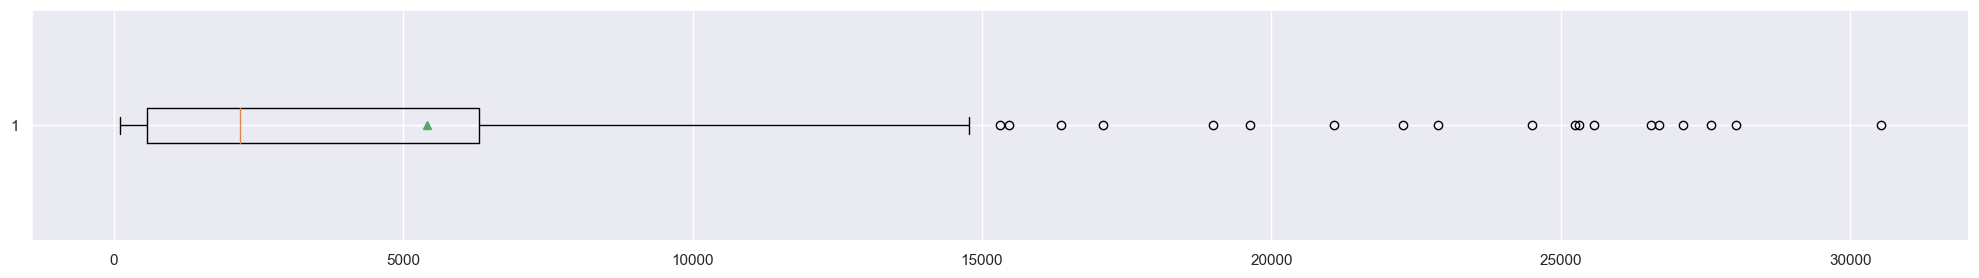

In [72]:
# Variable objetivo tendencia
plt.figure(figsize=(25, 3))
plt.boxplot(archivo_taller2_fil[archivo_taller2_fil['incomeperperson']<= archivo_taller2_fil['incomeperperson'].quantile(0.95)]["incomeperperson"] , showmeans=True, vert=False)
plt.show()

In [73]:
# 'breastcancerper100th','co2emissions','internetuserate','lifeexpectancy','relectricperperson','alcconsumption'

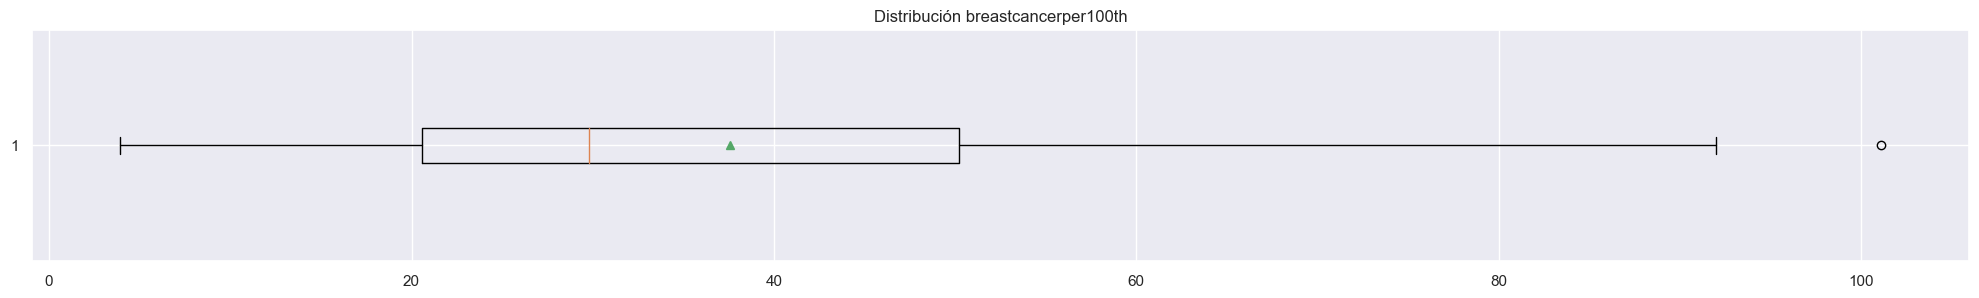

In [74]:
plt.figure(figsize=(25, 3))
plt.boxplot(archivo_taller2_fil[["breastcancerper100th"]] , showmeans=True, vert=False)
plt.title("Distribución breastcancerper100th")
plt.show()

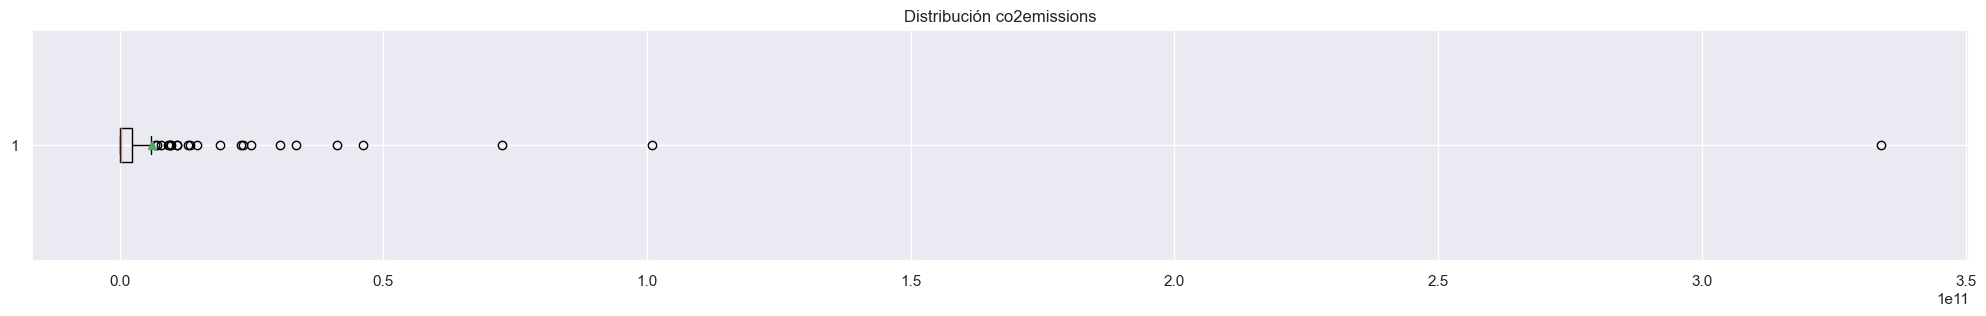

In [75]:
plt.figure(figsize=(25, 3))
plt.boxplot(archivo_taller2_fil["co2emissions"] , showmeans=True, vert=False)
plt.title("Distribución co2emissions")
plt.show()

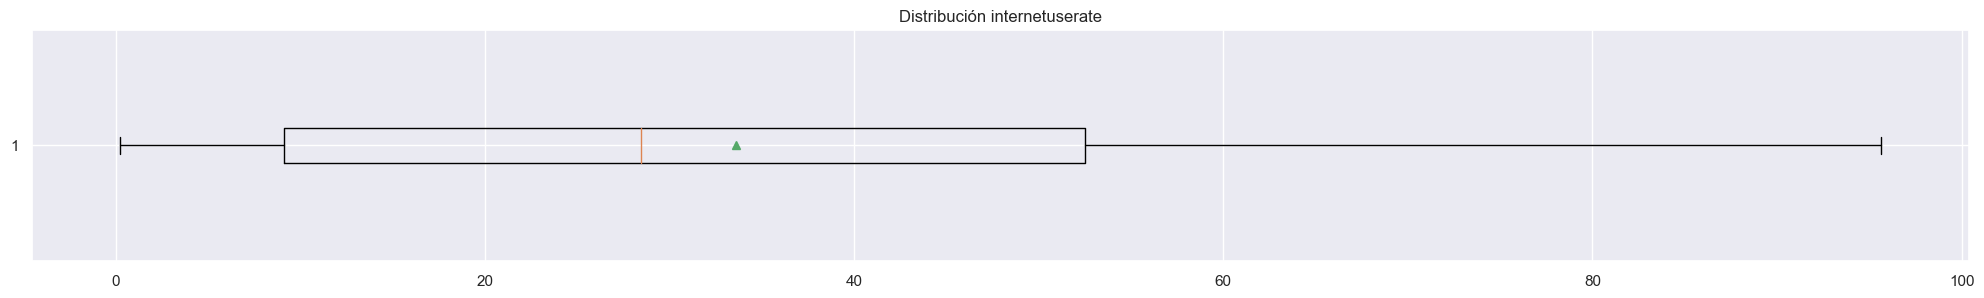

In [76]:
plt.figure(figsize=(25, 3))
plt.boxplot(archivo_taller2_fil[["internetuserate"]] , showmeans=True, vert=False)
plt.title("Distribución internetuserate")
plt.show()

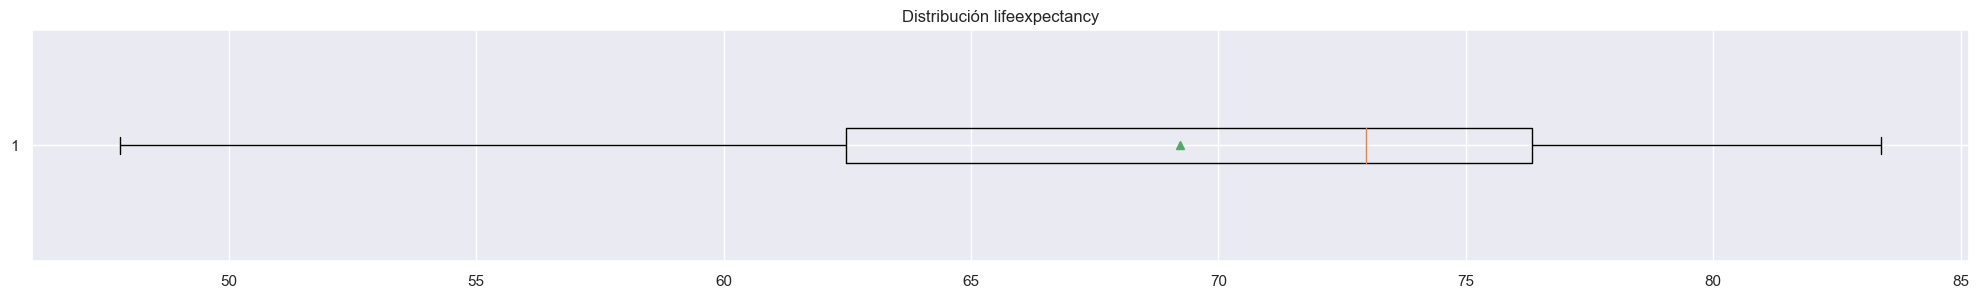

In [77]:
plt.figure(figsize=(25, 3))
plt.boxplot(archivo_taller2_fil[["lifeexpectancy"]] , showmeans=True, vert=False)
plt.title("Distribución lifeexpectancy")
plt.show()

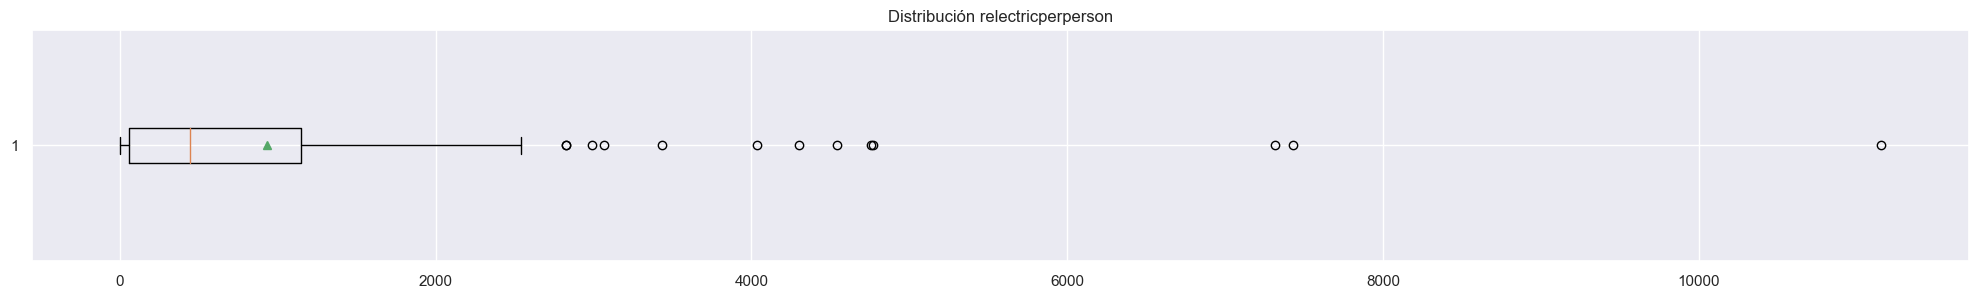

In [78]:
plt.figure(figsize=(25, 3))
plt.boxplot(archivo_taller2_fil[["relectricperperson"]] , showmeans=True, vert=False)
plt.title("Distribución relectricperperson")
plt.show()

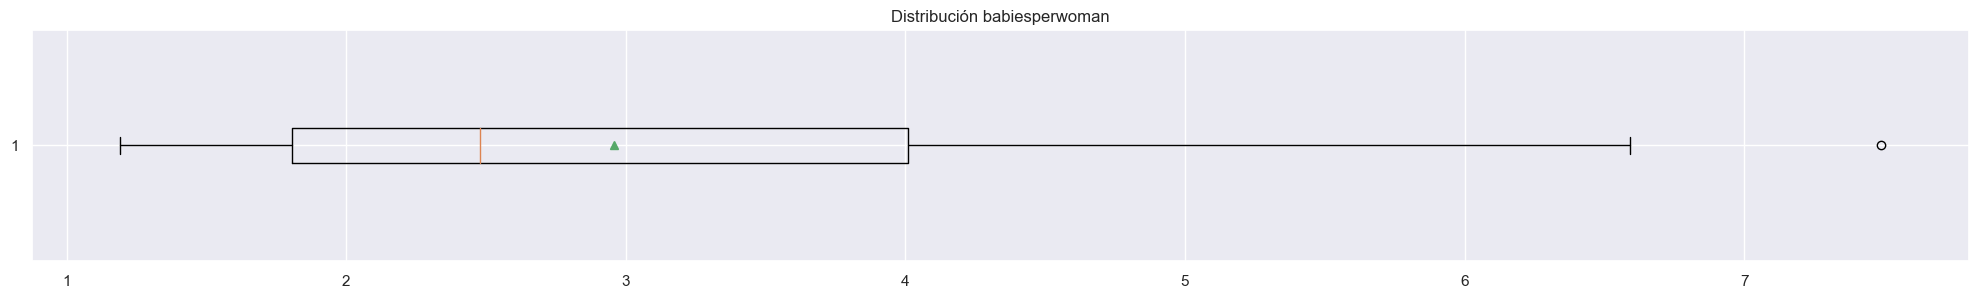

In [79]:
plt.figure(figsize=(25, 3))
plt.boxplot(archivo_taller2_fil[["babiesperwoman"]] , showmeans=True, vert=False)
plt.title("Distribución babiesperwoman")
plt.show()

In [80]:
# Visualizar analisis sin outliers

In [81]:
archivo_taller2_fil.columns

Index(['country', 'incomeperperson', 'alcconsumption', 'armedforcesrate',
       'breastcancerper100th', 'co2emissions', 'femaleemployrate', 'hivrate',
       'internetuserate', 'lifeexpectancy', 'polityscore',
       'relectricperperson', 'suicideper100th', 'employrate', 'urbanrate',
       'country_mod', 'name', 'region', 'sub-region', 'poblacion',
       'babiesperwoman', 'total_areakm2', 'tierra_area_km2', 'agua_area_km2',
       '% water', 'densidadpoblacional'],
      dtype='object')

In [82]:
df_visualizar= archivo_taller2_fil.loc[archivo_taller2_fil["incomeperperson"] <= archivo_taller2_fil["incomeperperson"].quantile(.95)]
df_visualizar= df_visualizar.loc[df_visualizar["co2emissions"] <= df_visualizar["co2emissions"].quantile(.95)]
df_visualizar= df_visualizar.loc[df_visualizar["hivrate"] <= df_visualizar["hivrate"].quantile(.95)]
df_visualizar= df_visualizar.loc[df_visualizar["relectricperperson"] <= df_visualizar["relectricperperson"].quantile(.95)]

In [83]:
df_visualizar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131 entries, 0 to 176
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   country               131 non-null    object 
 1   incomeperperson       131 non-null    float64
 2   alcconsumption        131 non-null    float64
 3   armedforcesrate       131 non-null    float64
 4   breastcancerper100th  131 non-null    float64
 5   co2emissions          131 non-null    float64
 6   femaleemployrate      131 non-null    float64
 7   hivrate               131 non-null    float64
 8   internetuserate       131 non-null    float64
 9   lifeexpectancy        131 non-null    float64
 10  polityscore           131 non-null    float64
 11  relectricperperson    131 non-null    float64
 12  suicideper100th       131 non-null    float64
 13  employrate            131 non-null    float64
 14  urbanrate             131 non-null    float64
 15  country_mod           1

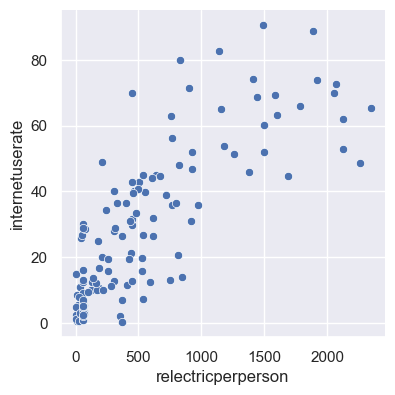

In [123]:
sns.pairplot(df_visualizar, height=4, y_vars="internetuserate", x_vars="relectricperperson", kind="scatter")

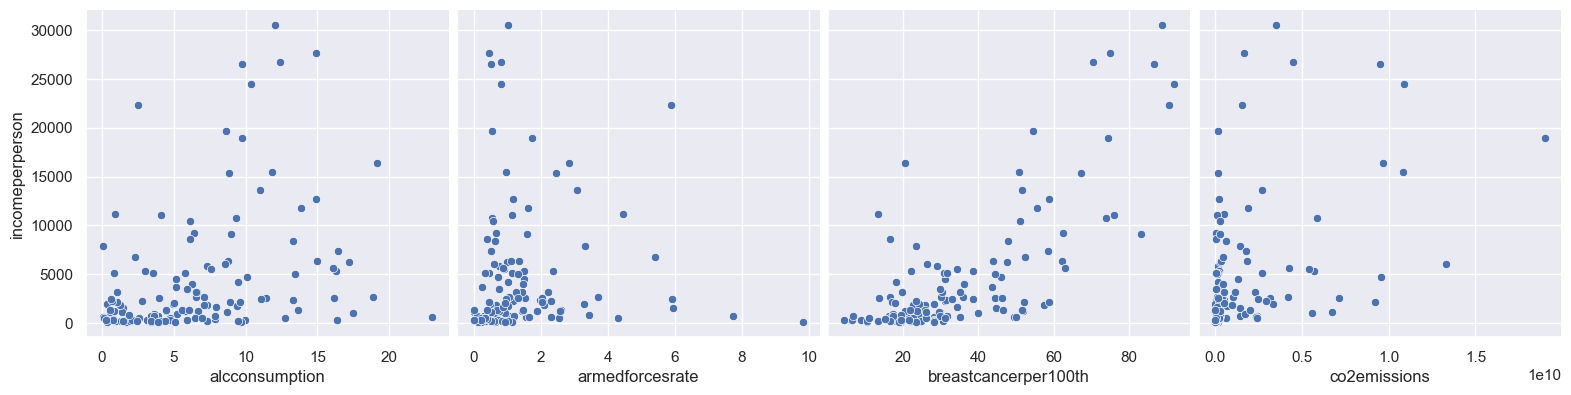

In [84]:
sns.pairplot(df_visualizar, height=4, y_vars="incomeperperson", x_vars=features[1:5], kind="scatter")

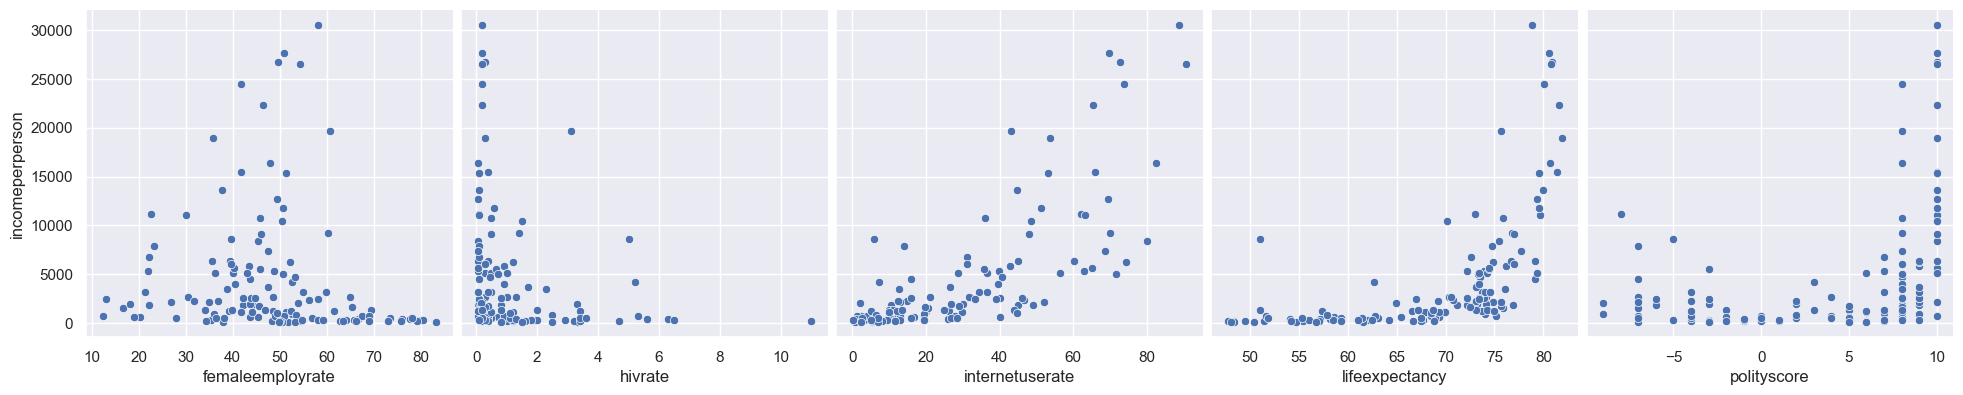

In [85]:
sns.pairplot(df_visualizar, height=4, y_vars="incomeperperson", x_vars=features[5:10], kind="scatter")

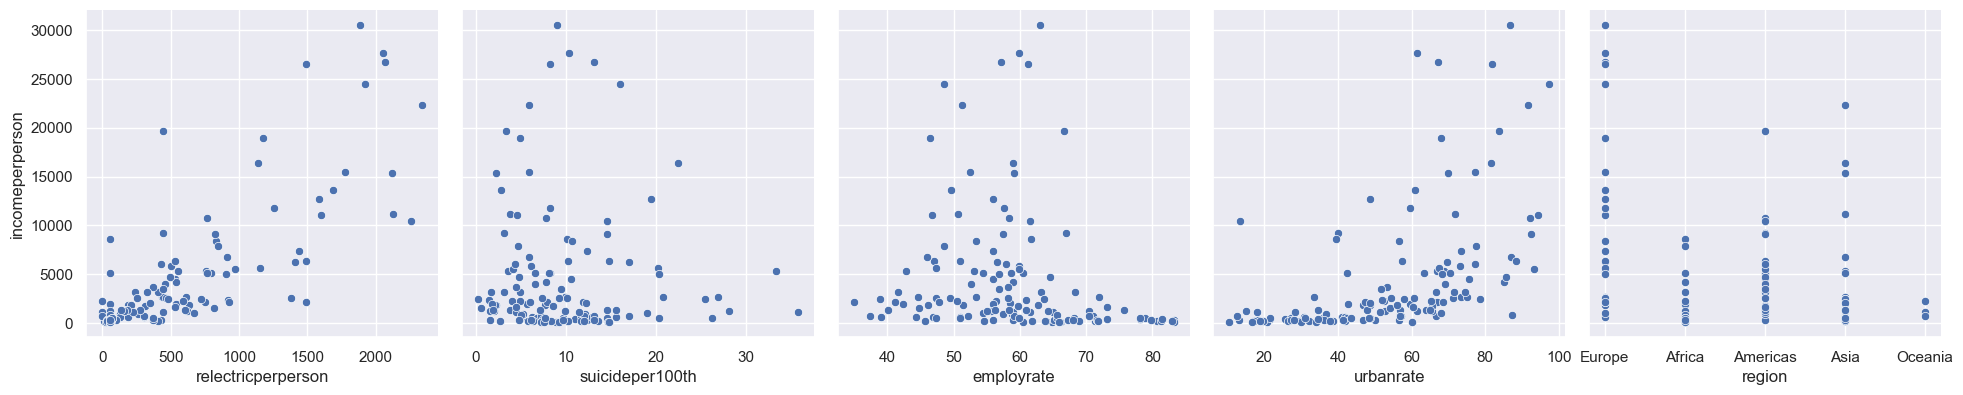

In [86]:
sns.pairplot(df_visualizar, height=4, y_vars="incomeperperson", x_vars=features[10:15], kind="scatter")

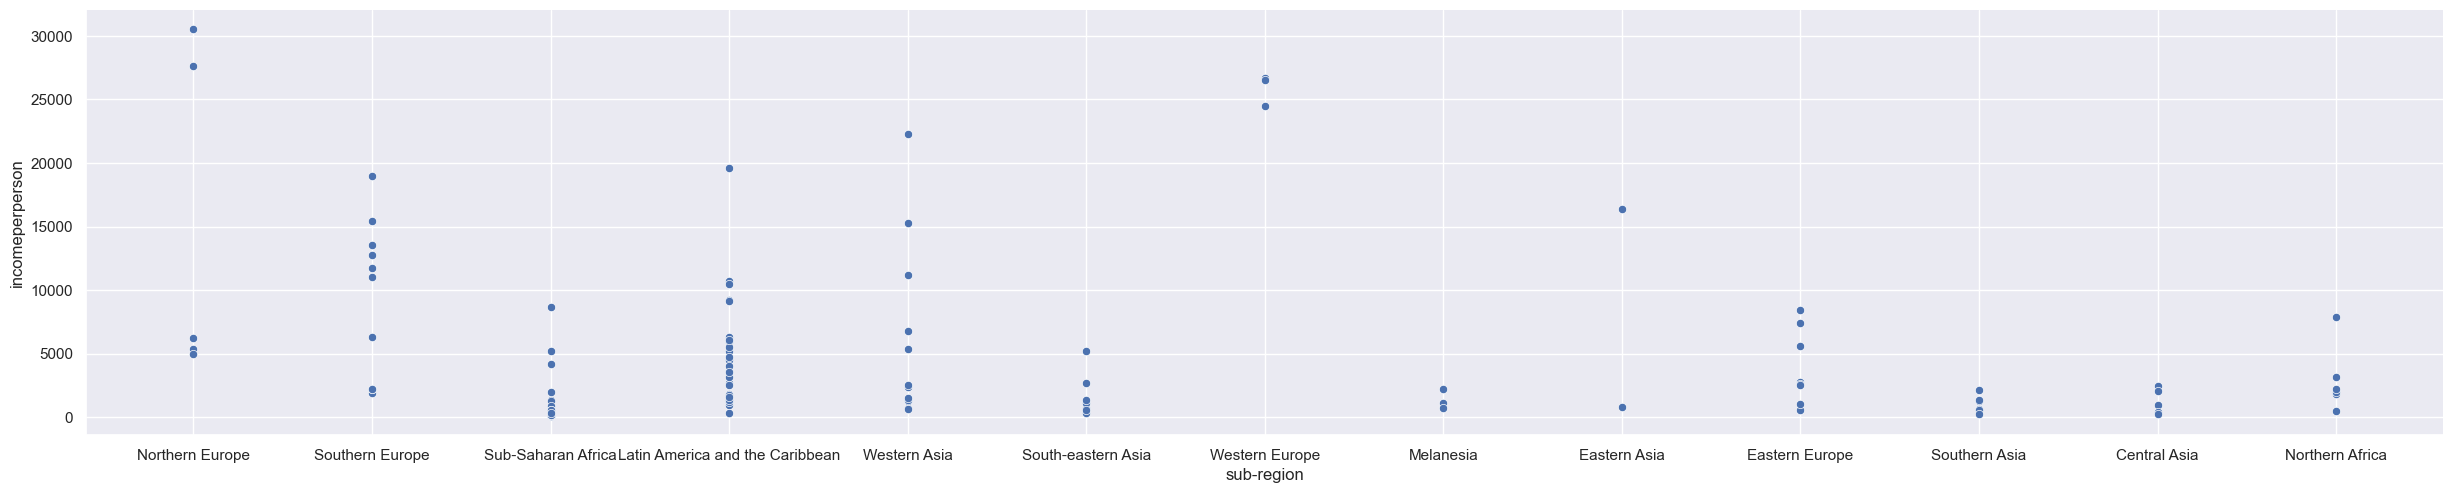

In [87]:
sns.pairplot(df_visualizar, height=5,aspect=5, y_vars="incomeperperson", x_vars=features[15], kind="scatter")

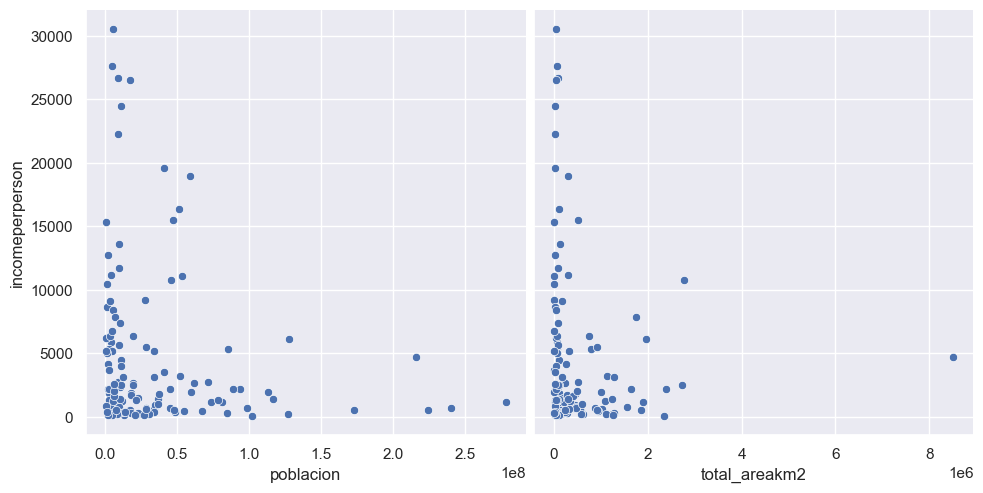

In [88]:
sns.pairplot(df_visualizar, height=5, y_vars="incomeperperson", x_vars=features[16:18], kind="scatter")

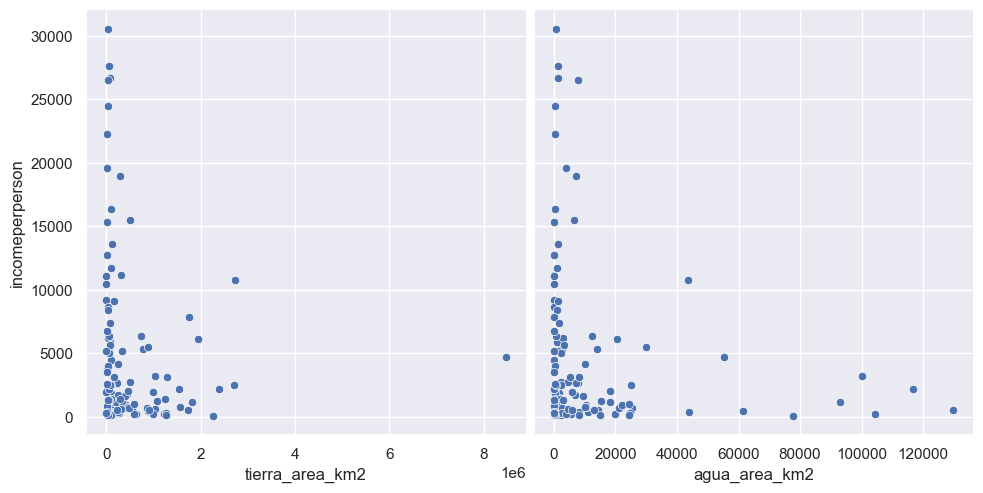

In [89]:
sns.pairplot(df_visualizar, height=5, y_vars="incomeperperson", x_vars=features[18:20], kind="scatter")

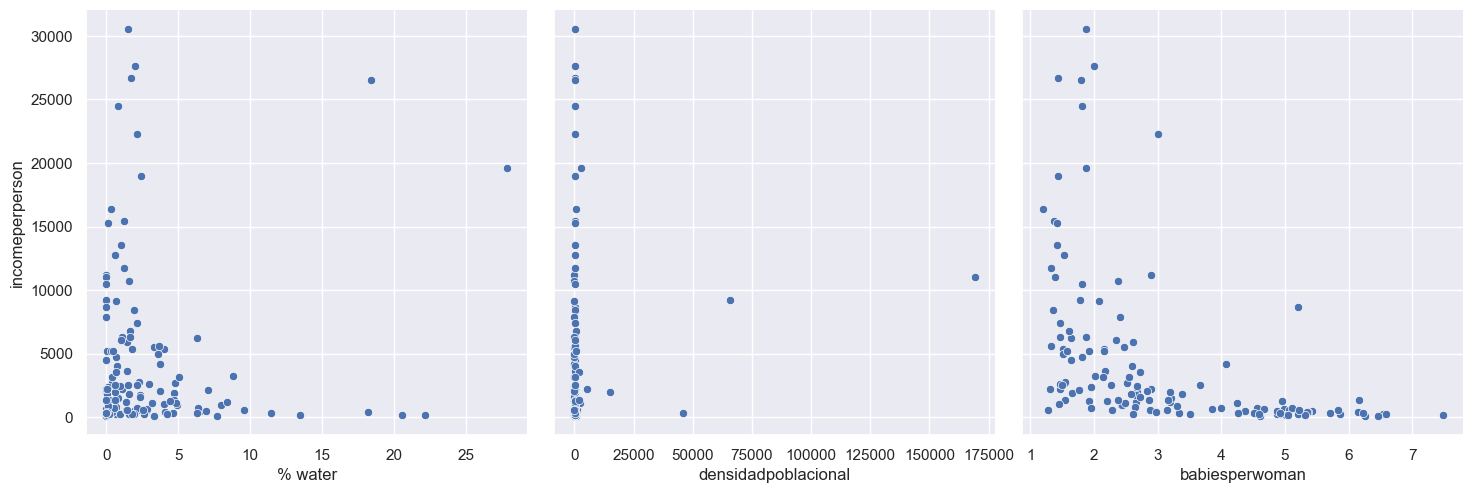

In [90]:
sns.pairplot(df_visualizar, height=5, y_vars="incomeperperson", x_vars=features[20:], kind="scatter")

<AxesSubplot:>

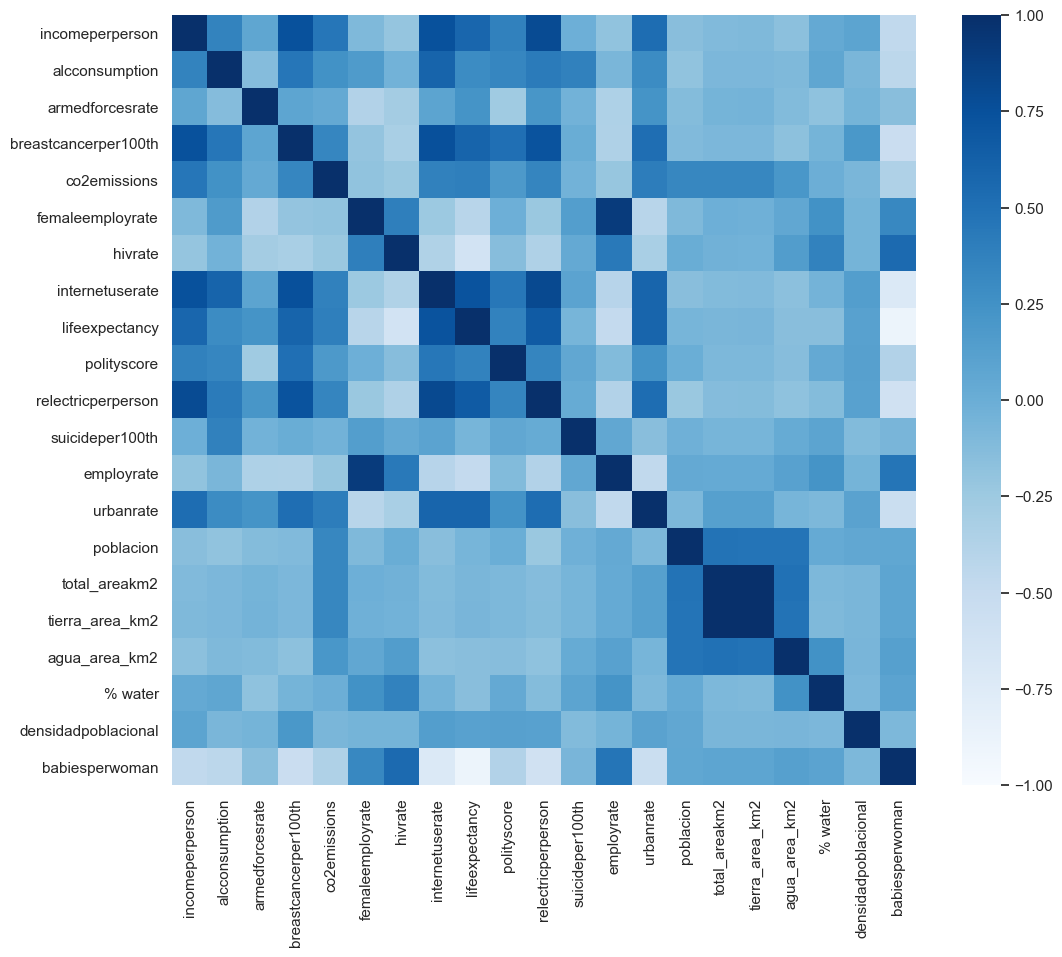

In [91]:
plt.figure(figsize=(12, 10))
sns.heatmap(df_visualizar[features].corr(), cmap="Blues", vmin=-1, vmax=1)

In [92]:
df_visualizar[features].corr()

,incomeperperson,alcconsumption,armedforcesrate,breastcancerper100th,co2emissions,femaleemployrate,hivrate,internetuserate,lifeexpectancy,polityscore,...,suicideper100th,employrate,urbanrate,poblacion,total_areakm2,tierra_area_km2,agua_area_km2,% water,densidadpoblacional,babiesperwoman
incomeperperson,1.000000,0.362125,0.074771,0.742349,0.458551,-0.096730,-0.210351,0.742238,0.579827,0.377759,...,-0.014060,-0.181381,0.526771,-0.147916,-0.103591,-0.100830,-0.158171,0.045480,0.092883,-0.464980
alcconsumption,0.362125,1.000000,-0.132455,0.455568,0.244329,0.167707,-0.036449,0.597141,0.296514,0.340786,...,0.378288,-0.070652,0.294088,-0.182128,-0.080695,-0.079304,-0.096896,0.074647,-0.071736,-0.437074
armedforcesrate,0.074771,-0.132455,1.000000,0.081370,0.040862,-0.373264,-0.287191,0.088148,0.232411,-0.261442,...,-0.038834,-0.348889,0.231969,-0.123094,-0.048400,-0.046161,-0.111955,-0.179606,-0.050796,-0.148103
breastcancerper100th,0.742349,0.455568,0.081370,1.000000,0.339806,-0.199015,-0.320112,0.750151,0.599730,0.514111,...,0.009472,-0.355077,0.518931,-0.102945,-0.083816,-0.080501,-0.169403,-0.051085,0.198611,-0.531824
co2emissions,0.458551,0.244329,0.040862,0.339806,1.000000,-0.181381,-0.229462,0.381213,0.398297,0.182890,...,-0.035976,-0.216043,0.408210,0.334516,0.333296,0.332182,0.204995,-0.004094,-0.072221,-0.354895
femaleemployrate,-0.096730,0.167707,-0.373264,-0.199015,-0.181381,1.000000,0.398364,-0.236390,-0.406845,-0.009172,...,0.145693,0.907093,-0.410158,-0.100638,-0.014811,-0.016508,0.061890,0.242839,-0.052713,0.323522
hivrate,-0.210351,-0.036449,-0.287191,-0.320112,-0.229462,0.398364,1.000000,-0.363693,-0.619905,-0.137068,...,0.041647,0.442214,-0.320025,0.012038,-0.029972,-0.034010,0.148664,0.368115,-0.047538,0.548070
internetuserate,0.742238,0.597141,0.088148,0.750151,0.381213,-0.236390,-0.363693,1.000000,0.726965,0.446489,...,0.098645,-0.403270,0.586238,-0.141660,-0.110515,-0.107852,-0.160398,-0.039850,0.148416,-0.712013
lifeexpectancy,0.579827,0.296514,0.232411,0.599730,0.398297,-0.406845,-0.619905,0.726965,1.000000,0.373426,...,-0.062149,-0.489093,0.589130,-0.056519,-0.071789,-0.069098,-0.146896,-0.146468,0.112963,-0.890408
polityscore,0.377759,0.340786,-0.261442,0.514111,0.182890,-0.009172,-0.137068,0.446489,0.373426,1.000000,...,0.059468,-0.111003,0.238501,0.004572,-0.091962,-0.089599,-0.138192,0.042138,0.121838,-0.371103


In [93]:
df_visualizar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131 entries, 0 to 176
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   country               131 non-null    object 
 1   incomeperperson       131 non-null    float64
 2   alcconsumption        131 non-null    float64
 3   armedforcesrate       131 non-null    float64
 4   breastcancerper100th  131 non-null    float64
 5   co2emissions          131 non-null    float64
 6   femaleemployrate      131 non-null    float64
 7   hivrate               131 non-null    float64
 8   internetuserate       131 non-null    float64
 9   lifeexpectancy        131 non-null    float64
 10  polityscore           131 non-null    float64
 11  relectricperperson    131 non-null    float64
 12  suicideper100th       131 non-null    float64
 13  employrate            131 non-null    float64
 14  urbanrate             131 non-null    float64
 15  country_mod           1

## Escogencia de variables y definición datasets

In [135]:
lm = smf.ols(formula = 'incomeperperson ~ co2emissions+relectricperperson+internetuserate+babiesperwoman', data=df_visualizar).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        incomeperperson   R-squared:                       0.705
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     75.25
Date:                Sun, 08 Oct 2023   Prob (F-statistic):           1.84e-32
Time:                        03:16:50   Log-Likelihood:                -1252.8
No. Observations:                 131   AIC:                             2516.
Df Residuals:                     126   BIC:                             2530.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -4585.8851   1341.396     -3.419      0.001   -7240.469   -1931.301
co2emissions        4.182e-07    1.1e-07      3.788      0.000       2e-07    6.37e-07
relectricperperson     5.9221      0.887      6.680      0.000       4.168       7.677
internetuserate       96.0730     25.233      3.807      0.000      46.137     146.009
babiesperwoman       773.9643    281.634      2.748      0.007     216.619    1331.309
==============================================================================
Omnibus:                       46.710   Durbin-Watson:                   2.044
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              152.593
Skew:                           1.289   Prob(JB):                     7.33e-34
Kurtosis:                       7.616   Cond. No.                     1.52e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.52e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [136]:
# A partir de todo lo mostrado anteriormente se escogen las siguientes variables
# Escoger variables según la colinealidad y listo
# variables_x=['breastcancerper100th','co2emissions','internetuserate','lifeexpectancy','relectricperperson','urbanrate','alcconsumption','polityscore','babiesperwoman']
# variables_x=['breastcancerper100th','co2emissions','internetuserate','lifeexpectancy','relectricperperson','alcconsumption']
variables_x=['co2emissions','relectricperperson','internetuserate','babiesperwoman']
# variables_x=['breastcancerper100th','co2emissions','relectricperperson']


In [137]:
df_visualizar[variables_x].corr()

,co2emissions,relectricperperson,internetuserate,babiesperwoman
co2emissions,1.000000,0.344763,0.381213,-0.354895
relectricperperson,0.344763,1.000000,0.807255,-0.600382
internetuserate,0.381213,0.807255,1.000000,-0.712013
babiesperwoman,-0.354895,-0.600382,-0.712013,1.000000


In [138]:
X = df_visualizar[variables_x]
Y = df_visualizar["incomeperperson"]

In [139]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=101)

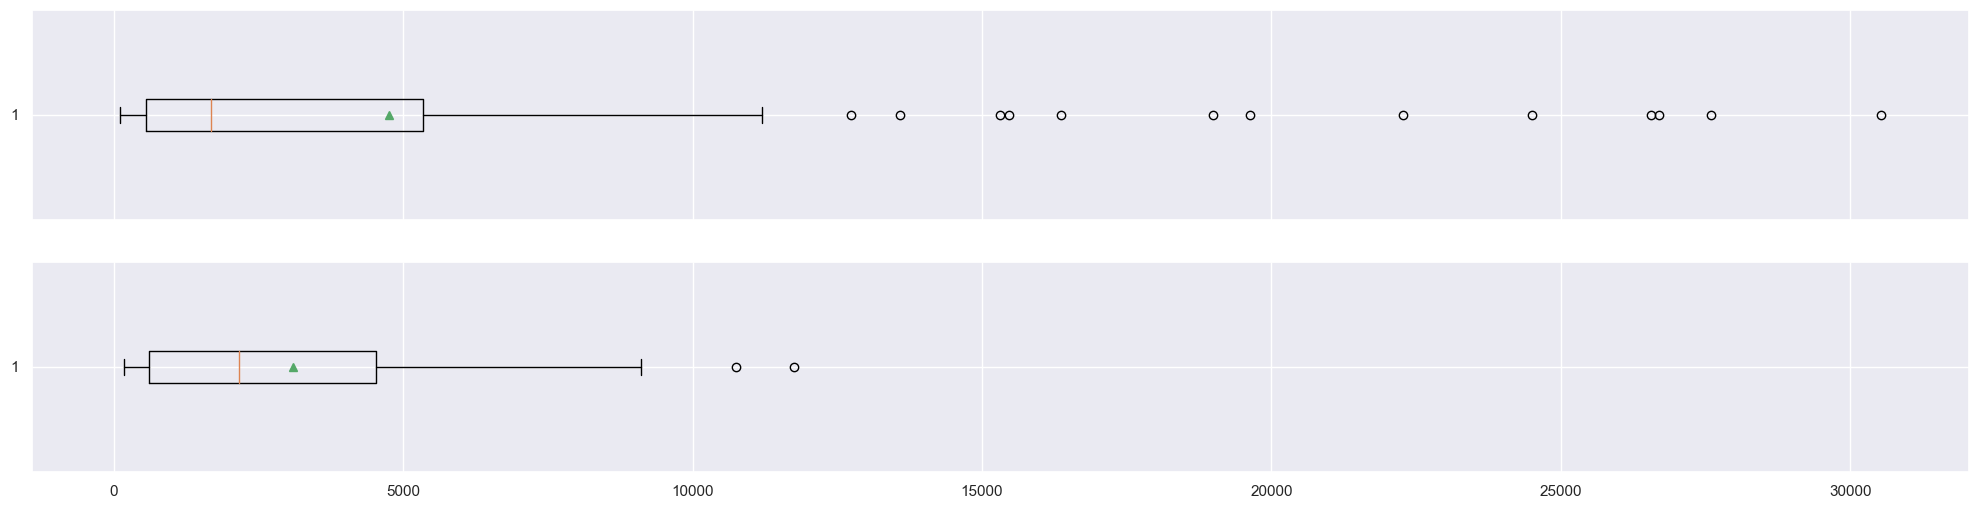

In [140]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(25, 6))
ax1.boxplot(Y_train, showmeans=True, vert=False)
ax2.boxplot(Y_test, showmeans=True, vert=False)
plt.show()

# Proceso de normalización

In [141]:
scaler = StandardScaler()

In [142]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [143]:
pd.DataFrame(data=X_train_scaled)

,0,1,2,3
0,-0.470957,-0.787810,-0.524759,1.222898
1,0.596229,-0.026313,-0.087846,0.043424
2,-0.463388,-0.393346,0.456535,-1.167588
3,-0.510475,-0.781862,-1.090180,1.979781
4,-0.463864,0.387839,0.309149,-0.757610
...,...,...,...,...
99,-0.467488,-0.172172,0.572974,-0.789147
100,0.240506,-0.235572,0.309180,-0.700844
101,1.341207,0.190317,0.638093,-1.054056
102,-0.432611,-0.579563,-0.748484,0.163263


# Creación modelo

In [144]:
model = LinearRegression()

In [145]:
model.fit(X_train_scaled, Y_train)

LinearRegression()

In [146]:
coefficients_df = pd.concat([
    pd.Series(variables_x),
    pd.Series(model.coef_)
], axis=1).rename(columns={0: "feature", 1: "value"})
coefficients_df

,feature,value
0,co2emissions,1327.476309
1,relectricperperson,3757.770263
2,internetuserate,2515.538399
3,babiesperwoman,1260.955746


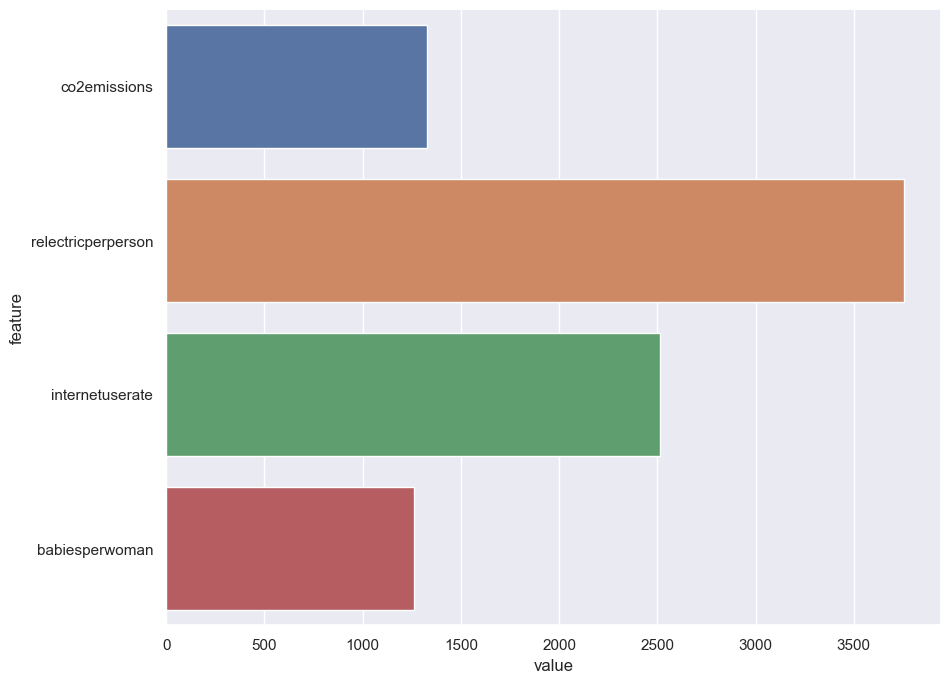

In [147]:
plt.figure(figsize=(10, 8))
sns.barplot(
    y=coefficients_df["feature"],
    x=coefficients_df["value"],
    orient="h"
)
plt.show()

# Evaluar el modelo

In [148]:
preds_train = model.predict(X_train_scaled)
preds_test = model.predict(X_test_scaled)

In [149]:
print("MAE train:", mean_absolute_error(Y_train, preds_train))
print("MAE test:", mean_absolute_error(Y_test, preds_test))

MAE train: 2387.8577563495073
MAE test: 2252.775596242583


In [150]:
print("RMSE train:", np.sqrt(mean_squared_error(Y_train, preds_train)))
print("RMSE test:", np.sqrt(mean_squared_error(Y_test, preds_test)))

RMSE train: 3611.7154630030736
RMSE test: 2782.164800820231


In [151]:
print("R2 score:", r2_score(Y_train, preds_train))

R2 score: 0.7249024589450854


# Analisis del error

In [152]:
(Y_test - preds_test).describe(percentiles=[.25, .5, .75, .95, .99])

count      27.000000
mean    -1093.946237
std      2606.799618
min     -6518.807009
25%     -2971.065554
50%      -987.342090
75%       894.272474
95%      2384.021012
99%      2620.660998
max      2674.970733
Name: incomeperperson, dtype: float64

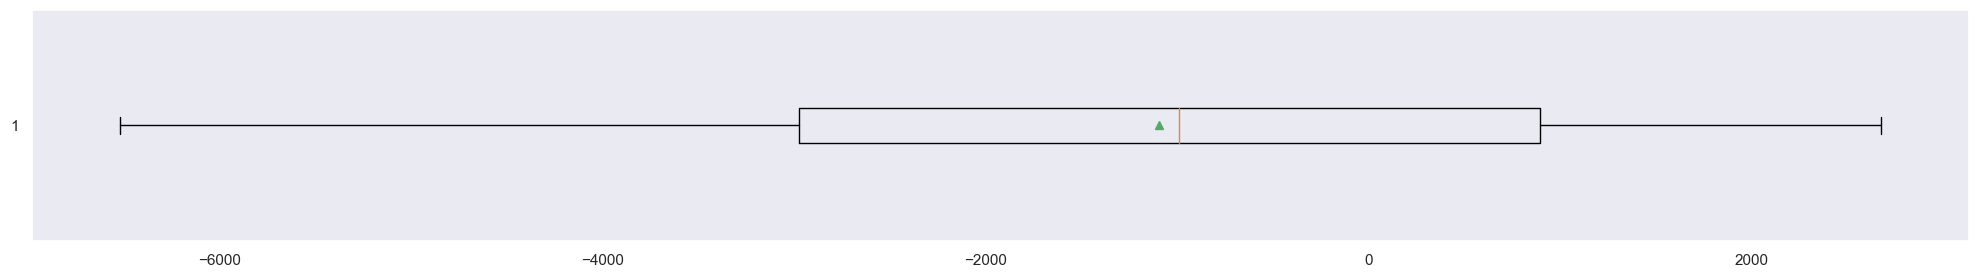

In [153]:
plt.figure(figsize = (25, 3))
plt.boxplot((Y_test - preds_test), showmeans=True, vert=False)
plt.grid()
plt.show()

In [154]:
worst_condition = np.where(np.abs(Y_test - preds_test) > 3500, True, False)

In [155]:
worst_cases = pd.concat([
    X_test.loc[worst_condition],
    Y_test.loc[worst_condition]
], axis=1).reset_index(drop=True)

In [156]:
worst_cases["predictions"] = pd.Series(preds_test).loc[worst_condition].reset_index(drop=True)

In [157]:
worst_cases.shape

(6, 6)

In [158]:
worst_cases

,co2emissions,relectricperperson,internetuserate,babiesperwoman,incomeperperson,predictions
0,2.364193e+08,927.119497,52.002061,1.31,2183.344867,7328.928476
1,2.771707e+08,1411.230532,74.163040,1.64,6238.537506,12757.344515
2,5.111077e+08,921.562111,46.679702,1.96,2344.896916,7389.263412
3,5.418886e+09,969.004339,35.850437,2.47,5528.363114,9132.206086
4,9.183548e+09,753.209802,13.000111,1.77,2161.546510,6612.676057
5,3.773037e+08,719.476530,38.881202,3.66,2534.000380,6681.999597
